Importaciones necesarias

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Vamos a visualizar como vienen cargados los datos, que hay en cada arreglo

# Estructura de los datos


In [2]:
data = np.load('arrows8_keras_format.npz', allow_pickle=True)
print("Llaves:", data.files)
for k in data.files:
    print(k, type(data[k]), data[k].shape)

Llaves: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'class_names']
x_train <class 'numpy.ndarray'> (4274, 8, 8, 1)
y_train <class 'numpy.ndarray'> (4274,)
x_val <class 'numpy.ndarray'> (4039, 8, 8, 1)
y_val <class 'numpy.ndarray'> (4039,)
x_test <class 'numpy.ndarray'> (4078, 8, 8, 1)
y_test <class 'numpy.ndarray'> (4078,)
class_names <class 'numpy.ndarray'> (4,)


podemos observar que vienen 8 arrays, cada uno con un proposito distinto:
* x_train = Datos de entrenamiento
* y_train = Etiquetas de entrenamiento
* x_val = Datos de validación
* y_val = Etiquetas de validación
* x_test = Datos de prueba
* y_test = Etiquetas de prueba
* class_names = Nombres de las clases

Ademas de eso tenemos(8,8,1):
* 8 × 8: el tamaño de la imagen en píxeles
* 1: el canal (grises). Si fuera RGB serían (8, 8, 3)
    Así que cada imagen es una matriz 8x8, como si fuera un mini mosaico de intensidades de gris

# Extraemos los datos que vienen en el .npz

In [3]:
X_train = data["x_train"]
y_train = data["y_train"]
X_val = data["x_val"]
y_val = data["y_val"]
X_test = data["x_test"]
y_test = data["y_test"]
class_names = data["class_names"]

In [4]:
print("Los nombres de las clases son:", class_names)

Los nombres de las clases son: ['up' 'left' 'down' 'right']


# Visualizacion de ejemplos:

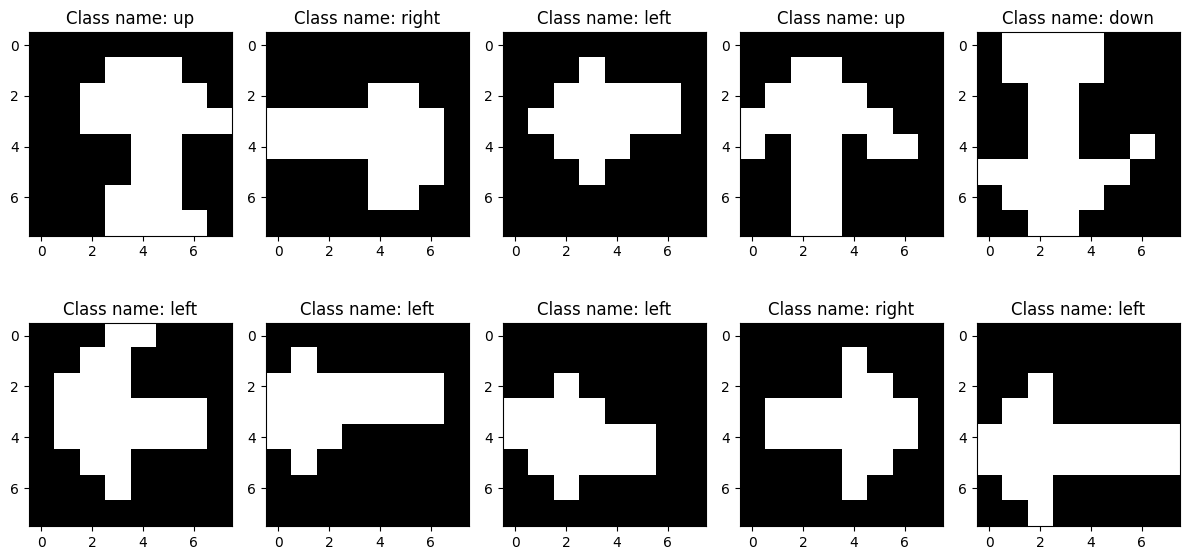

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten() #convertimos arreglo 2d en vector de 8 ejes

for i  in range(10):
    img = X_train[i+10].reshape(8, 8) #Toma la i-ésima imagen y la remodela a matriz 8×8.
                                      #x_train[i] venía como vector de longitud 64; si ya fuera (8,8), no haría falta reshape.
    label = class_names[y_train[i+10]] # acá tomamos el nombre de la clase de la i-esima imagen
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'Class name: {label}')

plt.tight_layout()
plt.show()

# Analisis de calidad de los datos

In [6]:

print("Valores NaN en X_train:", np.isnan(X_train).sum())
print("Valores NaN en y_train:", np.isnan(y_train).sum())
print("Valores NaN en X_val:", np.isnan(X_val).sum())
print("Valores NaN en y_val:", np.isnan(y_val).sum())
print("Valores NaN en X_test:", np.isnan(X_test).sum())
print("Valores NaN en y_test:", np.isnan(y_test).sum())

print("\nValores infinitos en X_train:", np.isinf(X_train).sum())
print("Valores infinitos en X_val:", np.isinf(X_val).sum())
print("Valores infinitos en X_test:", np.isinf(X_test).sum())

print("\nEstadísticas de X_train:")
print(f"Media: {X_train.mean():.4f}")
print(f"Desviación estándar: {X_train.std():.4f}")
print(f"Mediana: {np.median(X_train):.4f}")
print(f"Valores únicos en y_train: {np.unique(y_train)}")



Valores NaN en X_train: 0
Valores NaN en y_train: 0
Valores NaN en X_val: 0
Valores NaN en y_val: 0
Valores NaN en X_test: 0
Valores NaN en y_test: 0

Valores infinitos en X_train: 0
Valores infinitos en X_val: 0
Valores infinitos en X_test: 0

Estadísticas de X_train:
Media: 0.3302
Desviación estándar: 0.4703
Mediana: 0.0000
Valores únicos en y_train: [0 1 2 3]


# Distribucion de las clases
* ahora vamos a ver como están distribuidas las clases en cada uno de los conjuntos de datos con el fin de analizar si es necesario implementar
  alguna tecnica de balanceo de clases


ENTRENAMIENTO:
------------------------------
Clase 0 (up): 1061 muestras (24.8%)
Clase 1 (left): 1082 muestras (25.3%)
Clase 2 (down): 1039 muestras (24.3%)
Clase 3 (right): 1092 muestras (25.5%)
Relación de desbalance: 1.05
Diferencia máxima: 53 muestras

VALIDACIÓN:
------------------------------
Clase 0 (up): 1007 muestras (24.9%)
Clase 1 (left): 1010 muestras (25.0%)
Clase 2 (down): 1006 muestras (24.9%)
Clase 3 (right): 1016 muestras (25.2%)
Relación de desbalance: 1.01
Diferencia máxima: 10 muestras

PRUEBA:
------------------------------
Clase 0 (up): 1027 muestras (25.2%)
Clase 1 (left): 1024 muestras (25.1%)
Clase 2 (down): 1008 muestras (24.7%)
Clase 3 (right): 1019 muestras (25.0%)
Relación de desbalance: 1.02
Diferencia máxima: 19 muestras


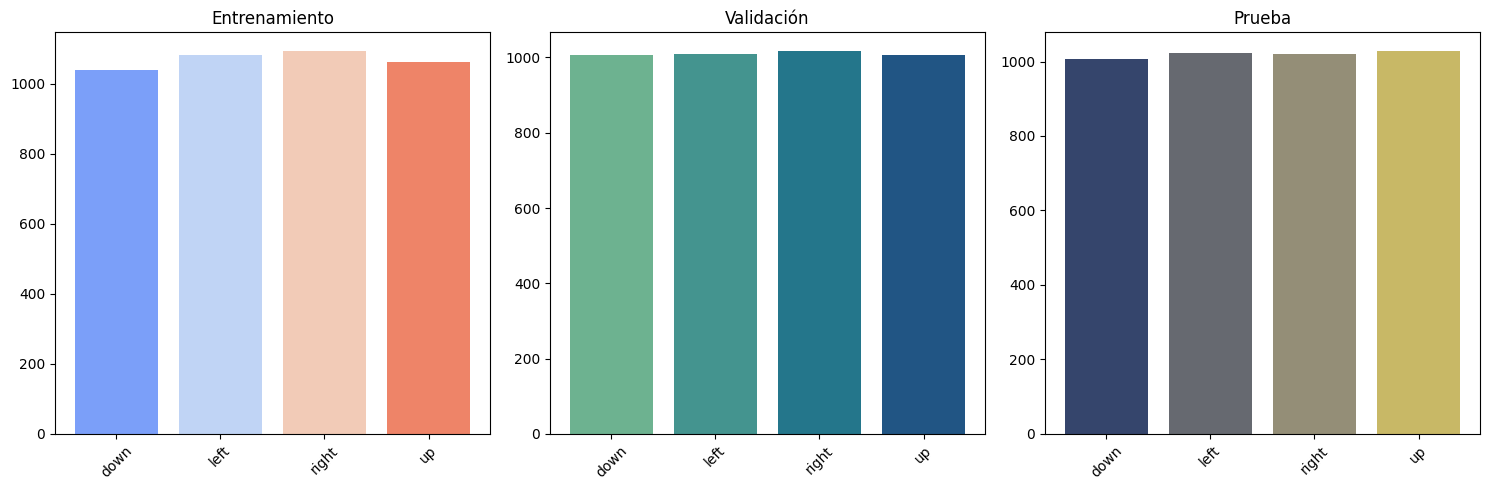

Máximo ratio de desbalance: 1.05
¿Necesita técnicas de balanceo? No
Criterio: ratio > 1.5


In [7]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

def analizar_balance_clases(y, nombre_conjunto):
    counts = Counter(y)
    total = len(y)

    print(f"\n{nombre_conjunto}:")
    print("-" * 30)

    for i, clase in enumerate(class_names):
        cantidad = counts[i]
        porcentaje = (cantidad / total) * 100
        print(f"Clase {i} ({clase}): {cantidad} muestras ({porcentaje:.1f}%)")

    max_samples = max(counts.values())
    min_samples = min(counts.values())
    ratio_desbalance = max_samples / min_samples

    print(f"Relación de desbalance: {ratio_desbalance:.2f}")
    print(f"Diferencia máxima: {max_samples - min_samples} muestras")

    return counts, ratio_desbalance


train_counts, train_ratio = analizar_balance_clases(y_train, "ENTRENAMIENTO")
val_counts, val_ratio = analizar_balance_clases(y_val, "VALIDACIÓN")
test_counts, test_ratio = analizar_balance_clases(y_test, "PRUEBA")



df_train = pd.DataFrame({'Clase': [class_names[i] for i in train_counts.keys()], 'Cantidad': list(train_counts.values())})
df_val = pd.DataFrame({'Clase': [class_names[i] for i in val_counts.keys()], 'Cantidad': list(val_counts.values())})
df_test = pd.DataFrame({'Clase': [class_names[i] for i in test_counts.keys()], 'Cantidad': list(test_counts.values())})

clases = df_train['Clase'].unique()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

train_counts = df_train.groupby('Clase')['Cantidad'].sum()
colors_train = sns.color_palette('coolwarm', len(train_counts))

ax[0].bar(train_counts.index, train_counts.values, color=colors_train)
ax[0].set_title('Entrenamiento')
ax[0].tick_params(axis='x', rotation=45)

val_counts = df_val.groupby('Clase')['Cantidad'].sum()
colors_val = sns.color_palette('crest', len(val_counts))

ax[1].bar(val_counts.index, val_counts.values, color=colors_val)
ax[1].set_title('Validación')
ax[1].tick_params(axis='x', rotation=45)

test_counts = df_test.groupby('Clase')['Cantidad'].sum()
colors_test = sns.color_palette('cividis', len(test_counts))

ax[2].bar(test_counts.index, test_counts.values, color=colors_test)
ax[2].set_title('Prueba')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

print(f"Máximo ratio de desbalance: {max(train_ratio, val_ratio, test_ratio):.2f}")

umbral_balanceo = 1.5
necesita_balanceo = max(train_ratio, val_ratio, test_ratio) > umbral_balanceo

print(f"¿Necesita técnicas de balanceo? {'Sí' if necesita_balanceo else 'No'}")
print(f"Criterio: ratio > {umbral_balanceo}")



# Analisis de distribucion de pixeles

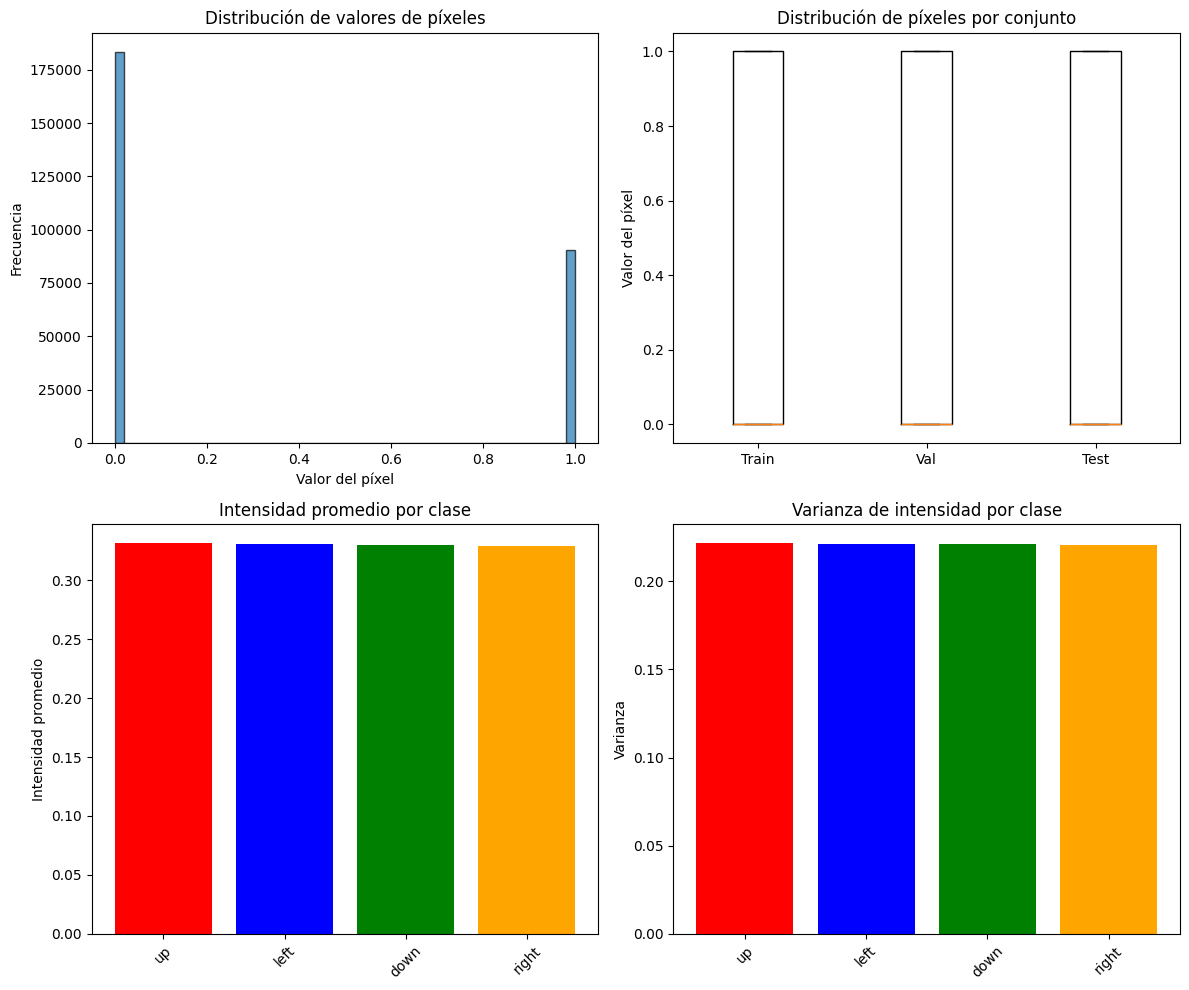

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(X_train.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribución de valores de píxeles')
axes[0,0].set_xlabel('Valor del píxel')
axes[0,0].set_ylabel('Frecuencia')

data_boxplot = [X_train.flatten(), X_val.flatten(), X_test.flatten()]
axes[0,1].boxplot(data_boxplot, labels=['Train', 'Val', 'Test'])
axes[0,1].set_title('Distribución de píxeles por conjunto')
axes[0,1].set_ylabel('Valor del píxel')

class_means = []
for i in range(len(class_names)):
    mask = y_train == i
    mean_intensity = X_train[mask].mean()
    class_means.append(mean_intensity)

axes[1,0].bar(class_names, class_means, color=['red', 'blue', 'green', 'orange'])
axes[1,0].set_title('Intensidad promedio por clase')
axes[1,0].set_ylabel('Intensidad promedio')
axes[1,0].tick_params(axis='x', rotation=45)

class_vars = []
for i in range(len(class_names)):
    mask = y_train == i
    var_intensity = X_train[mask].var()
    class_vars.append(var_intensity)

axes[1,1].bar(class_names, class_vars, color=['red', 'blue', 'green', 'orange'])
axes[1,1].set_title('Varianza de intensidad por clase')
axes[1,1].set_ylabel('Varianza')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Analisis y reducción de características

Análisis de correlacion


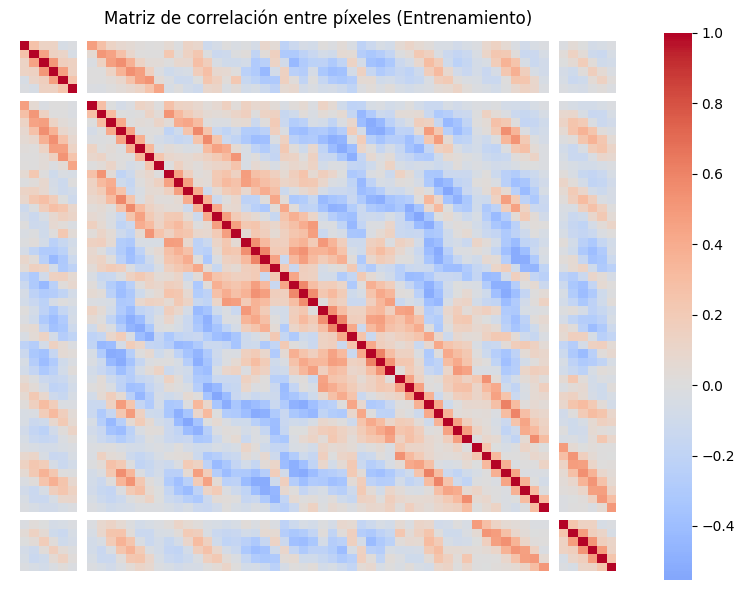

In [9]:
X_flat = X_train.reshape(X_train.shape[0], -1)
cols = [f'p_{i}_{j}' for i in range(8) for j in range(8)]
df_pixels = pd.DataFrame(X_flat, columns=cols)
df_pixels.head()
corr_matrix = df_pixels.corr()
corr_matrix.shape
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Matriz de correlación entre píxeles (Entrenamiento)")
plt.tight_layout()
plt.show()

Podemos observar que existe una fuerte correlación positiva entre pixeles vecinos (cerca de la diagonal principal), lo cual indica que pixeles vecinos tienden a tomar valores parecidos:
* O son parte del fondo (negro), o bien son parte del cuerpo de la flecha (blanco).

Observamos la continuidad espacial de las flechas, es decir: No aparecen pixeles blancos aislados, sino manchas continuas.

La estructura de la matriz de correlación es esperable, concuerda con la naturaleza de las imagenes.
Las zonas centrales están más correlacionadas, mientras que, regiones simetricas a ambos lados musetran correlaciones negativas, esto se debe a las distintas direcciones de las flechas.

# Resumen de inspeccion y análisis de datos
1.** Análisis de estructura de los datos**
  * Dataset de imágenes 8x8 píxeles en escala de grises
  * 4 clases: 'up', 'left', 'down', 'right' (flechas direccionales)
  * División ya realizada: entrenamiento, validación y prueba
  * Total: 12,391 muestras distribuidas apropiadamente
2. **Vefificación de calidad de los Datos**
  * Sin valores faltantes (NaN)
  * Sin valores infinitos
  * Consistencia en etiquetas entre conjuntos
  * Datos ya normalizados en rango [0, 1]

3. **El dataset está balanceado en clases.**

4. **Las imágenes son pequeñas (8×8) y binarias, con formas muy claras.**

5. **La matriz de correlación muestra:**

  * fuerte dependencia local entre píxeles vecinos

  * Cierta exclusión entre regiones opuestas de la imagen,

  * correlaciones en general moderadas, sin redundancia excesiva.

  * no es necesario hacer una reducción de dimensionalidad agresiva (son solo 64 variables),


# Preparacion y vectorización de los datos

In [10]:
print("Asegurar tipos de datos")
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
X_test  = X_test.astype('float32')
y_train = y_train.astype('int32')
y_val   = y_val.astype('int32')
y_test  = y_test.astype('int32')

Asegurar tipos de datos


**Normalización adicional no es necesaria porque el rango ya es [0,1]**

In [11]:
print("one-hot encoding de las etiquetas")
from tensorflow.keras.utils import to_categorical
num_classes= len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)

one-hot encoding de las etiquetas
(4274, 4) (4039, 4) (4078, 4)
(4274, 4) (4039, 4) (4078, 4)


* Antes: y_train era (4274,), con valores 0,1,2,3.

* Ahora: y_train_cat es (4274, 4) con vectores como [0,1,0,0].

In [12]:
from sklearn.utils import shuffle

X_train, y_train_cat = shuffle(X_train, y_train_cat, random_state=42)

**Se mezcló el conjunto de entrenamiento para reducir posibles efectos de ordenamiento en el proceso de optimización.**

In [13]:
print("Formas originales:")
print(f"X_train original: {X_train.shape}")
print(f"X_val original: {X_val.shape}")
print(f"X_test original: {X_test.shape}")

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nDespués de vectorización:")
print(f"X_train_flat: {X_train_flat.shape}")
print(f"X_val_flat: {X_val_flat.shape}")
print(f"X_test_flat: {X_test_flat.shape}")

Formas originales:
X_train original: (4274, 8, 8, 1)
X_val original: (4039, 8, 8, 1)
X_test original: (4078, 8, 8, 1)

Después de vectorización:
X_train_flat: (4274, 64)
X_val_flat: (4039, 64)
X_test_flat: (4078, 64)


Ahora verifiquemos que no se perdieron datos:

In [14]:
print(f"Original: {X_train.size} píxeles")
print(f"Vectorizado: {X_train_flat.size} píxeles")

Original: 273536 píxeles
Vectorizado: 273536 píxeles


**Resumen de la preparación e los datos:**
1.  Se cargaron los conjuntos de entrenamiento, validación y prueba desde el archivo .npz.

2.  Las imágenes se convirtieron a tipo float32 manteniendo sus valores binarios en {0,1}.

3.  Las etiquetas enteras (0–3) se transformaron a codificación one-hot.

4.  El conjunto de entrenamiento se mezcló para evitar sesgos derivados del orden original de las muestras.

5. Se dejaron dos representaciones de los datos:

* Imágenes 8×8×1.

* Vectores de 64 características.

**Datos finales preparados**
* **X_train**, **X_val**, **X_test**: Datos normalizados
* **X_train_flat**, **X_val_flat**, **X_test_flat**: Datos vectorizados (64 características)
* **y_train_cat**, **y_val_cat**, **y_test_cat**: Etiquetas codificadas

# Implementación y experimentos de los modelos

In [15]:
# Importaciones adicionales para experimentos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

print("Framework experimental configurado exitosamente")
print("Problema: Clasificación multiclase (4 clases)")
print(f"Clases: {list(class_names)}")
print(f"Datos de entrenamiento: {X_train.shape[0]} muestras")
print(f"Datos de validación: {X_val.shape[0]} muestras") 
print(f"Datos de prueba: {X_test.shape[0]} muestras")
print(f"Características: {X_train_flat.shape[1]} píxeles")

Framework experimental configurado exitosamente
Problema: Clasificación multiclase (4 clases)
Clases: [np.str_('up'), np.str_('left'), np.str_('down'), np.str_('right')]
Datos de entrenamiento: 4274 muestras
Datos de validación: 4039 muestras
Datos de prueba: 4078 muestras
Características: 64 píxeles


In [16]:
# Combinar entrenamiento y validación para optimización de hiperparámetros
X_train_val = np.vstack([X_train_flat, X_val_flat])
y_train_val = np.hstack([y_train, y_val])

print(f"Conjunto combinado (train+val): {X_train_val.shape[0]} muestras")
print(f"Conjunto de prueba independiente: {X_test_flat.shape[0]} muestras")

# Función para evaluar modelos de forma consistente
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo):
    """Evalúa un modelo calculando múltiples métricas"""
    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    # Métricas
    resultados = {
        'Modelo': nombre_modelo,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Train_F1': f1_score(y_train, y_train_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_F1': f1_score(y_test, y_test_pred, average='weighted'),
        'Test_Precision': precision_score(y_test, y_test_pred, average='weighted'),
        'Test_Recall': recall_score(y_test, y_test_pred, average='weighted')
    }
    
    return resultados, y_test_pred

# Lista para almacenar resultados
resultados_experimentos = []
print("Función de evaluación configurada")
print("Métricas: Accuracy, F1-Score, Precision, Recall")

Conjunto combinado (train+val): 8313 muestras
Conjunto de prueba independiente: 4078 muestras
Función de evaluación configurada
Métricas: Accuracy, F1-Score, Precision, Recall


## 1. Regresión Logística Multivariada

La regresión logística multinomial emplea la función softmax para modelar probabilidades de clase, siendo especialmente eficaz cuando las clases son linealmente separables en el espacio de características.

### Configuración de hiperparámetros:

**Parámetro C**: [0.001, 0.01, 0.1, 1, 10, 100]  
El parámetro C representa el inverso de la intensidad de regularización. Se exploran valores desde 0.001 hasta 100 para encontrar el balance óptimo entre sesgo y varianza. Valores pequeños (0.001-0.1) imponen regularización fuerte, útil para prevenir sobreajuste en datasets de dimensionalidad moderada como el nuestro (64 características).

**Penalización**: ['l1', 'l2']  
Se evalúan ambas normas de regularización. L1 tiende a generar soluciones sparse, potencialmente útil dada la probable redundancia entre píxeles adyacentes. L2 distribuye los pesos de manera más uniforme, apropiado cuando las características están correlacionadas.

**Solver**: ['liblinear', 'saga']  
Liblinear resulta eficiente para problemas de tamaño moderado y soporta tanto L1 como L2. SAGA converge más rápidamente en algunos casos y maneja todas las combinaciones de penalización, ofreciendo una alternativa robusta.

**Iteraciones máximas**: [1000, 2000]  
Se establecen límites suficientes para garantizar convergencia, considerando que problemas de esta escala típicamente convergen antes de las 1000 iteraciones.

In [20]:
# EXPERIMENTO 1: REGRESIÓN LOGÍSTICA MULTIVARIADA
print("EXPERIMENTO 1: REGRESIÓN LOGÍSTICA MULTIVARIADA")
print("=" * 60)

inicio_tiempo = time.time()

# Definir hiperparámetros para optimizar
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],           # Regularización
    'penalty': ['l1', 'l2'],                       # Tipo de regularización
    'solver': ['liblinear', 'saga'],               # Algoritmo de optimización
    'max_iter': [1000, 2000]                      # Máximo número de iteraciones
}

# El espacio de búsqueda incluye diferentes valores de regularización (C),
# tipos de penalización (L1, L2) y algoritmos de optimización
total_combinations = (len(param_grid_logistic['C']) * 
                     len(param_grid_logistic['penalty']) * 
                     len(param_grid_logistic['solver']) * 
                     len(param_grid_logistic['max_iter']))
print(f"Espacio de búsqueda: {total_combinations} combinaciones de hiperparámetros")

# Crear modelo base
logistic_model = LogisticRegression(multi_class='multinomial', random_state=42)

# Configurar validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search_logistic = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid_logistic,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

print("\nIniciando búsqueda de hiperparámetros...")
grid_search_logistic.fit(X_train_val, y_train_val)

tiempo_total = time.time() - inicio_tiempo

print(f"\nOptimización completada en {tiempo_total:.2f} segundos")
print(f"Mejores parámetros: {grid_search_logistic.best_params_}")
print(f"Mejor score CV: {grid_search_logistic.best_score_:.4f}")

# Evaluar modelo optimizado
resultados_logistic, pred_logistic = evaluar_modelo(
    grid_search_logistic.best_estimator_, 
    X_train_val, y_train_val, 
    X_test_flat, y_test,
    "Logistic Regression"
)

resultados_experimentos.append(resultados_logistic)
print(f"Test Accuracy: {resultados_logistic['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {resultados_logistic['Test_F1']:.4f}")

EXPERIMENTO 1: REGRESIÓN LOGÍSTICA MULTIVARIADA
Espacio de búsqueda: 48 combinaciones de hiperparámetros

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Optimización completada en 19.45 segundos
Mejores parámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Mejor score CV: 0.5490
Test Accuracy: 0.8779
Test F1-Score: 0.8779


## 2. Árboles de Decisión

Los árboles de decisión particionan recursivamente el espacio de características mediante reglas binarias, construyendo un modelo interpretable pero susceptible al sobreajuste.

### Configuración de hiperparámetros:

**Profundidad máxima**: [3, 5, 7, 10, 15, None]  
La profundidad controla directamente la complejidad del modelo. Para imágenes de 8×8 píxeles, profundidades intermedias (5-10) suelen capturar patrones relevantes sin memorizar ruido. Se incluyen árboles poco profundos (3-5) como controles conservadores y árboles profundos (15, None) para explorar la capacidad máxima del modelo.

**Muestras mínimas para división**: [2, 5, 10, 20]  
Este parámetro previene divisiones en nodos con pocas muestras. Con aproximadamente 4000 muestras de entrenamiento, valores entre 2-20 ofrecen un rango razonable. Valores más altos (20) fuerzan mayor generalización, mientras que valores bajos (2) permiten especialización.

**Muestras mínimas por hoja**: [1, 2, 5, 10]  
Controla el tamaño mínimo de los nodos terminales. Hojas con una sola muestra pueden indicar memorización, mientras que hojas más grandes promueven generalización. El rango seleccionado balancea estos extremos.

**Criterio de impureza**: ['gini', 'entropy']  
Gini ofrece ventajas computacionales, mientras que entropy (ganancia de información) puede ser más sensible a cambios en la distribución de clases. Ambos criterios son estándar y efectivos para clasificación multiclase.

**Características por división**: [None, 'sqrt', 'log2', 0.5]  
Usar todas las características (None) permite divisiones óptimas, mientras que subconjuntos aleatorios introducen regularización. Para 64 características: 'sqrt'≈8, 'log2'≈6, y 0.5≈32 características por división.

In [21]:
# EXPERIMENTO 2: ÁRBOLES DE DECISIÓN
print("\nEXPERIMENTO 2: ÁRBOLES DE DECISIÓN")
print("=" * 60)

inicio_tiempo = time.time()

# Definir hiperparámetros para optimizar
param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 15, None],          # Profundidad máxima
    'min_samples_split': [2, 5, 10, 20],          # Mínimo muestras para dividir
    'min_samples_leaf': [1, 2, 5, 10],            # Mínimo muestras en hoja
    'criterion': ['gini', 'entropy'],             # Criterio de impureza
    'max_features': [None, 'sqrt', 'log2', 0.5]   # Número de características
}

# Optimización de parámetros para controlar la complejidad del árbol
# y evitar overfitting mediante restricciones en profundidad y tamaño de nodos
print(f"Optimizando {len(param_grid_tree['max_depth']) * len(param_grid_tree['min_samples_split']) * len(param_grid_tree['min_samples_leaf']) * len(param_grid_tree['criterion']) * len(param_grid_tree['max_features'])} configuraciones")

# Crear modelo base
tree_model = DecisionTreeClassifier(random_state=42)

# GridSearchCV
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid_tree,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

print("\nIniciando búsqueda de hiperparámetros...")
grid_search_tree.fit(X_train_val, y_train_val)

tiempo_total = time.time() - inicio_tiempo

print(f"\nOptimización completada en {tiempo_total:.2f} segundos")
print(f"Mejores parámetros: {grid_search_tree.best_params_}")
print(f"Mejor score CV: {grid_search_tree.best_score_:.4f}")

# Evaluar modelo optimizado
resultados_tree, pred_tree = evaluar_modelo(
    grid_search_tree.best_estimator_, 
    X_train_val, y_train_val, 
    X_test_flat, y_test,
    "Decision Tree"
)

resultados_experimentos.append(resultados_tree)
print(f"Test Accuracy: {resultados_tree['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {resultados_tree['Test_F1']:.4f}")


EXPERIMENTO 2: ÁRBOLES DE DECISIÓN
Optimizando 768 configuraciones

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits

Optimización completada en 5.57 segundos
Mejores parámetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Mejor score CV: 0.5930
Test Accuracy: 0.9529
Test F1-Score: 0.9530


## 3. Random Forest

Random Forest combina múltiples árboles de decisión entrenados en muestras bootstrap del dataset, reduciendo la varianza mediante promediado de predicciones.

### Configuración de hiperparámetros:

**Número de estimadores**: [50, 100, 200, 300]  
El número de árboles afecta directamente el rendimiento y tiempo de cómputo. Se exploran desde 50 árboles (ensemble básico) hasta 300 (ensemble robusto). En la práctica, los beneficios suelen estabilizarse alrededor de 100-200 árboles para problemas de esta escala.

**Profundidad máxima**: [5, 10, 15, None]  
A diferencia de árboles individuales, Random Forest puede usar árboles algo más simples ya que la diversidad del ensemble compensa la menor complejidad individual. Se evalúan desde árboles conservadores (profundidad 5) hasta árboles sin restricción.

**Parámetros de división**: min_samples_split [2, 5, 10], min_samples_leaf [1, 2, 4]  
Se usan rangos más conservadores que en árboles individuales. El ensemble naturalmente regulariza los modelos individuales, permitiendo configuraciones menos restrictivas sin riesgo significativo de sobreajuste.

**Características aleatorias**: ['sqrt', 'log2', None]  
La selección aleatoria de características es fundamental en Random Forest. 'sqrt' (≈8 características) es el valor estándar, 'log2' (≈6) introduce más aleatoriedad, y None elimina esta fuente de diversidad. Se omite deliberadamente el uso de todas las características para mantener la filosofía del algoritmo.

**Bootstrap**: [True, False]  
True corresponde a Random Forest clásico (muestreo con reemplazo), mientras que False implementa Extra-Trees (usa el dataset completo). Ambas variantes tienen mérito teórico y práctico.

In [22]:
# EXPERIMENTO 3: RANDOM FOREST
print("\nEXPERIMENTO 3: RANDOM FOREST")
print("=" * 60)

inicio_tiempo = time.time()

# Definir hiperparámetros para optimizar
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],           # Número de árboles
    'max_depth': [5, 10, 15, None],                # Profundidad máxima
    'min_samples_split': [2, 5, 10],               # Mínimo muestras para dividir
    'min_samples_leaf': [1, 2, 4],                 # Mínimo muestras en hoja
    'max_features': ['sqrt', 'log2', None],        # Características a considerar
    'bootstrap': [True, False]                     # Muestreo con/sin reemplazo
}

# Random Forest combina múltiples árboles con variaciones aleatorias
# en los datos de entrenamiento y selección de características
print(f"Evaluando ensemble con {param_grid_rf['n_estimators']} diferentes tamaños")
print(f"Configuraciones totales: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features']) * len(param_grid_rf['bootstrap'])}")

# Crear modelo base
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

print("\nIniciando búsqueda de hiperparámetros...")
grid_search_rf.fit(X_train_val, y_train_val)

tiempo_total = time.time() - inicio_tiempo

print(f"\nOptimización completada en {tiempo_total:.2f} segundos")
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor score CV: {grid_search_rf.best_score_:.4f}")

# Evaluar modelo optimizado
resultados_rf, pred_rf = evaluar_modelo(
    grid_search_rf.best_estimator_, 
    X_train_val, y_train_val, 
    X_test_flat, y_test,
    "Random Forest"
)

resultados_experimentos.append(resultados_rf)
print(f"Test Accuracy: {resultados_rf['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {resultados_rf['Test_F1']:.4f}")


EXPERIMENTO 3: RANDOM FOREST
Evaluando ensemble con [50, 100, 200, 300] diferentes tamaños
Configuraciones totales: 864

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Optimización completada en 734.08 segundos
Mejores parámetros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Mejor score CV: 0.6135
Test Accuracy: 0.9993
Test F1-Score: 0.9993


## 4. Perceptrón Multicapa (MLP)

El MLP consiste en capas densamente conectadas con funciones de activación no lineales, permitiendo aproximar funciones complejas mediante composición de transformaciones.

### Configuración de hiperparámetros:

**Topología de red**: [(50,), (100,), (150,), (50,25), (100,50), (150,75), (100,50,25)]  
Se evalúan arquitecturas desde simples (una capa oculta) hasta moderadamente profundas (tres capas). Las topologías siguen una reducción gradual hacia las 4 clases de salida. Para un problema con 64 entradas, estas configuraciones mantienen proporciones razonables entre capas.

**Función de activación**: ['relu', 'tanh', 'logistic']  
ReLU es el estándar actual por su simplicidad computacional y capacidad para mitigar gradientes evanescentes. Tanh ofrece salidas centradas en cero que pueden acelerar convergencia. La función logística, aunque menos común actualmente, se incluye como control histórico.

**Algoritmo de optimización**: ['adam', 'lbfgs']  
Adam es robusto para la mayoría de problemas de aprendizaje profundo. LBFGS, un método quasi-Newton, puede ser superior en problemas de tamaño pequeño a moderado como el nuestro, donde el cómputo de la Hessiana aproximada es factible.

**Regularización L2**: [0.0001, 0.001, 0.01]  
El parámetro alpha controla la penalización sobre los pesos. Se exploran tres órdenes de magnitud: regularización mínima (0.0001), moderada (0.001), y fuerte (0.01). Datasets pequeños típicamente requieren regularización moderada.

**Adaptación del learning rate**: ['constant', 'adaptive']  
El esquema constante mantiene la tasa fija, mientras que el adaptativo la reduce cuando el progreso se estanca. Este último puede prevenir oscilaciones en la convergencia.

**Criterio de parada**: max_iter [500, 1000] con early stopping habilitado  
Se establecen límites generosos pero se confía en el early stopping para prevenir sobreajuste, independientemente del límite de iteraciones.

In [23]:
# EXPERIMENTO 4: REDES NEURONALES - MLP
print("\nEXPERIMENTO 4: MLP (MULTI-LAYER PERCEPTRON)")
print("=" * 60)

inicio_tiempo = time.time()

# Definir hiperparámetros para optimizar
param_grid_mlp = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),                    # 1 capa oculta
        (50, 25), (100, 50), (150, 75),          # 2 capas ocultas
        (100, 50, 25)                            # 3 capas ocultas
    ],
    'activation': ['relu', 'tanh', 'logistic'],  # Función de activación
    'solver': ['adam', 'lbfgs'],                 # Algoritmo de optimización
    'alpha': [0.0001, 0.001, 0.01],             # Regularización L2
    'learning_rate': ['constant', 'adaptive'],   # Estrategia de learning rate
    'max_iter': [500, 1000]                     # Máximo número de iteraciones
}

# Evaluación de diferentes topologías de red, desde arquitecturas simples
# hasta redes más profundas con múltiples capas ocultas
print(f"Arquitecturas evaluadas: {len(param_grid_mlp['hidden_layer_sizes'])}")
print(f"Configuraciones totales: {len(param_grid_mlp['hidden_layer_sizes']) * len(param_grid_mlp['activation']) * len(param_grid_mlp['solver']) * len(param_grid_mlp['alpha']) * len(param_grid_mlp['learning_rate']) * len(param_grid_mlp['max_iter'])}")

# Crear modelo base
mlp_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)

# GridSearchCV
grid_search_mlp = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_mlp,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

print("\nIniciando búsqueda de hiperparámetros...")
grid_search_mlp.fit(X_train_val, y_train_val)

tiempo_total = time.time() - inicio_tiempo

print(f"\nOptimización completada en {tiempo_total:.2f} segundos")
print(f"Mejores parámetros: {grid_search_mlp.best_params_}")
print(f"Mejor score CV: {grid_search_mlp.best_score_:.4f}")

# Evaluar modelo optimizado
resultados_mlp, pred_mlp = evaluar_modelo(
    grid_search_mlp.best_estimator_, 
    X_train_val, y_train_val, 
    X_test_flat, y_test,
    "MLP Neural Network"
)

resultados_experimentos.append(resultados_mlp)
print(f"Test Accuracy: {resultados_mlp['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {resultados_mlp['Test_F1']:.4f}")


EXPERIMENTO 4: MLP (MULTI-LAYER PERCEPTRON)
Arquitecturas evaluadas: 7
Configuraciones totales: 504

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 504 candidates, totalling 2520 fits

Optimización completada en 4324.65 segundos
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Mejor score CV: 0.6115
Test Accuracy: 0.9899
Test F1-Score: 0.9900


## 5. Redes Neuronales Profundas (TensorFlow/Keras)

La implementación en TensorFlow permite mayor flexibilidad arquitectónica y control fino sobre el entrenamiento, incluyendo técnicas como dropout y optimización adapativa.

### Arquitecturas evaluadas:

Se diseñaron cuatro configuraciones que exploran diferentes balances entre capacidad representacional y regularización:

**Red moderada**: [128, 64] con dropout 0.3 y learning rate 0.001  
Arquitectura conservadora con reducción progresiva de neuronas. El dropout moderado y learning rate estándar ofrecen un punto de partida equilibrado.

**Red profunda**: [256, 128, 64] con dropout 0.4 y learning rate 0.0005  
Mayor capacidad representacional mediante una capa adicional. El incremento en dropout compensa la complejidad adicional, mientras que el learning rate reducido favorece convergencia estable.

**Red muy profunda**: [512, 256, 128, 64] con dropout 0.5 y learning rate 0.0001  
Máxima capacidad explorada, con dropout agresivo para controlar sobreajuste. El learning rate conservador evita inestabilidades durante la optimización.

**Red alternativa**: [128, 64, 32] con dropout 0.3 y learning rate 0.001  
Configuración que explora una reducción más gradual hacia la capa de salida, manteniendo parámetros conservadores.

### Justificación técnica:

La progresión en dropout (0.3→0.5) refleja la necesidad de mayor regularización en redes más profundas. La reducción correlativa del learning rate (0.001→0.0001) previene inestabilidades que pueden surgir con arquitecturas complejas. Se emplea Adam con parámetros estándar (β₁=0.9, β₂=0.999) y función de pérdida categorical crossentropy, apropiada para clasificación multiclase.

La selección de la mejor arquitectura se realiza mediante validación cruzada simplificada (3-fold por eficiencia computacional), priorizando el balance entre rendimiento y estabilidad.

In [25]:
# EXPERIMENTO 5: RED NEURONAL PROFUNDA (DNN) CON TENSORFLOW/KERAS
print("\nEXPERIMENTO 5: DNN CON TENSORFLOW/KERAS")
print("=" * 60)

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    
    print("TensorFlow disponible")
    
    # Configurar para reproducibilidad
    tf.random.set_seed(42)
    
    # Crear y_train_val_cat para Keras
    y_train_val_cat = to_categorical(y_train_val, num_classes=4)
    
    inicio_tiempo = time.time()
    
    # Definir arquitecturas a probar
    arquitecturas = [
        {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001},
        {'layers': [256, 128, 64], 'dropout': 0.4, 'lr': 0.0005},
        {'layers': [512, 256, 128, 64], 'dropout': 0.5, 'lr': 0.0001},
        {'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.001}
    ]
    
    # Exploración sistemática de arquitecturas con diferente profundidad
    # y parámetros de regularización (dropout) y optimización (learning rate)
    print(f"Evaluando {len(arquitecturas)} arquitecturas diferentes:")
    for i, arch in enumerate(arquitecturas, 1):
        capas_str = ' → '.join(map(str, arch['layers']))
        print(f"   {i}. {capas_str} (dropout={arch['dropout']}, lr={arch['lr']})")
    
    mejor_accuracy = 0
    mejor_modelo = None
    mejor_config = None
    
    for i, config in enumerate(arquitecturas):
        print(f"\nEntrenando arquitectura {i+1}/{len(arquitecturas)}...")
        
        # Validación cruzada manual simplificada (3 folds para rapidez)
        cv_scores = []
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        for train_idx, val_idx in skf.split(X_train_val, y_train_val):
            X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
            y_train_fold, y_val_fold = y_train_val_cat[train_idx], y_train_val_cat[val_idx]
            
            # Crear modelo
            model = keras.Sequential()
            model.add(layers.Dense(config['layers'][0], activation='relu', input_shape=(64,)))
            model.add(layers.Dropout(config['dropout']))
            
            for neurons in config['layers'][1:]:
                model.add(layers.Dense(neurons, activation='relu'))
                model.add(layers.Dropout(config['dropout']))
            
            model.add(layers.Dense(4, activation='softmax'))
            
            # Compilar
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=config['lr']),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # Entrenar
            history = model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=50,
                batch_size=32,
                verbose=0
            )
            
            # Evaluar
            val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            cv_scores.append(val_acc)
        
        cv_mean = np.mean(cv_scores)
        print(f"   CV Accuracy: {cv_mean:.4f} ± {np.std(cv_scores):.4f}")
        
        if cv_mean > mejor_accuracy:
            mejor_accuracy = cv_mean
            mejor_config = config
            
            # Entrenar modelo final en todo el dataset
            final_model = keras.Sequential()
            final_model.add(layers.Dense(config['layers'][0], activation='relu', input_shape=(64,)))
            final_model.add(layers.Dropout(config['dropout']))
            
            for neurons in config['layers'][1:]:
                final_model.add(layers.Dense(neurons, activation='relu'))
                final_model.add(layers.Dropout(config['dropout']))
            
            final_model.add(layers.Dense(4, activation='softmax'))
            final_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=config['lr']),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            final_model.fit(X_train_val, y_train_val_cat, epochs=100, batch_size=32, verbose=0)
            mejor_modelo = final_model
    
    tiempo_total = time.time() - inicio_tiempo
    
    print(f"\nOptimización completada en {tiempo_total:.2f} segundos")
    print(f"Mejor configuración: {mejor_config}")
    print(f"Mejor CV Accuracy: {mejor_accuracy:.4f}")
    
    # Evaluar en conjunto de prueba
    test_pred_proba = mejor_modelo.predict(X_test_flat, verbose=0)
    test_pred = np.argmax(test_pred_proba, axis=1)
    
    train_pred_proba = mejor_modelo.predict(X_train_val, verbose=0)
    train_pred = np.argmax(train_pred_proba, axis=1)
    
    # Calcular métricas
    resultados_dnn = {
        'Modelo': 'DNN (TensorFlow)',
        'Train_Accuracy': accuracy_score(y_train_val, train_pred),
        'Train_F1': f1_score(y_train_val, train_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_test, test_pred),
        'Test_F1': f1_score(y_test, test_pred, average='weighted'),
        'Test_Precision': precision_score(y_test, test_pred, average='weighted'),
        'Test_Recall': recall_score(y_test, test_pred, average='weighted')
    }
    
    resultados_experimentos.append(resultados_dnn)
    pred_dnn = test_pred
    print(f"Test Accuracy: {resultados_dnn['Test_Accuracy']:.4f}")
    print(f"Test F1-Score: {resultados_dnn['Test_F1']:.4f}")
    
except ImportError:
    print("TensorFlow no está disponible. Saltando experimento DNN.")
    print("Instalar con: pip install tensorflow")
    
    # Crear resultados placeholder
    resultados_dnn = {
        'Modelo': 'DNN (TensorFlow)',
        'Train_Accuracy': 'N/A',
        'Train_F1': 'N/A', 
        'Test_Accuracy': 'N/A',
        'Test_F1': 'N/A',
        'Test_Precision': 'N/A',
        'Test_Recall': 'N/A'
    }
    resultados_experimentos.append(resultados_dnn)
    pred_dnn = None


EXPERIMENTO 5: DNN CON TENSORFLOW/KERAS
TensorFlow disponible
Evaluando 4 arquitecturas diferentes:
   1. 128 → 64 (dropout=0.3, lr=0.001)
   2. 256 → 128 → 64 (dropout=0.4, lr=0.0005)
   3. 512 → 256 → 128 → 64 (dropout=0.5, lr=0.0001)
   4. 128 → 64 → 32 (dropout=0.3, lr=0.001)

Entrenando arquitectura 1/4...
   CV Accuracy: 0.6019 ± 0.0019
   CV Accuracy: 0.6019 ± 0.0019

Entrenando arquitectura 2/4...

Entrenando arquitectura 2/4...
   CV Accuracy: 0.6012 ± 0.0021

Entrenando arquitectura 3/4...
   CV Accuracy: 0.6012 ± 0.0021

Entrenando arquitectura 3/4...
   CV Accuracy: 0.6119 ± 0.0005
   CV Accuracy: 0.6119 ± 0.0005

Entrenando arquitectura 4/4...

Entrenando arquitectura 4/4...
   CV Accuracy: 0.5997 ± 0.0021

Optimización completada en 280.71 segundos
Mejor configuración: {'layers': [512, 256, 128, 64], 'dropout': 0.5, 'lr': 0.0001}
Mejor CV Accuracy: 0.6119
   CV Accuracy: 0.5997 ± 0.0021

Optimización completada en 280.71 segundos
Mejor configuración: {'layers': [512, 256

## Análisis Comparativo de Resultados

Evaluación de la efectividad de cada modelo optimizado mediante validación cruzada.


Resultados de validación en conjunto de prueba:
                Modelo  Train_Accuracy  Train_F1  Test_Accuracy  Test_F1  \
0  Logistic Regression          0.5570    0.5569         0.8779   0.8779   
1        Decision Tree          0.6125    0.6125         0.9529   0.9530   
2  Logistic Regression          0.5570    0.5569         0.8779   0.8779   
3        Decision Tree          0.6125    0.6125         0.9529   0.9530   
4        Random Forest          0.6149    0.6149         0.9993   0.9993   
5   MLP Neural Network          0.6115    0.6114         0.9899   0.9900   
6     DNN (TensorFlow)          0.6226    0.6227         0.9819   0.9819   

   Test_Precision  Test_Recall  
0          0.8784       0.8779  
1          0.9534       0.9529  
2          0.8784       0.8779  
3          0.9534       0.9529  
4          0.9993       0.9993  
5          0.9901       0.9899  
6          0.9823       0.9819  

Ranking por performance en test:
1. Random Forest: 0.9993
2. MLP Neural Netwo

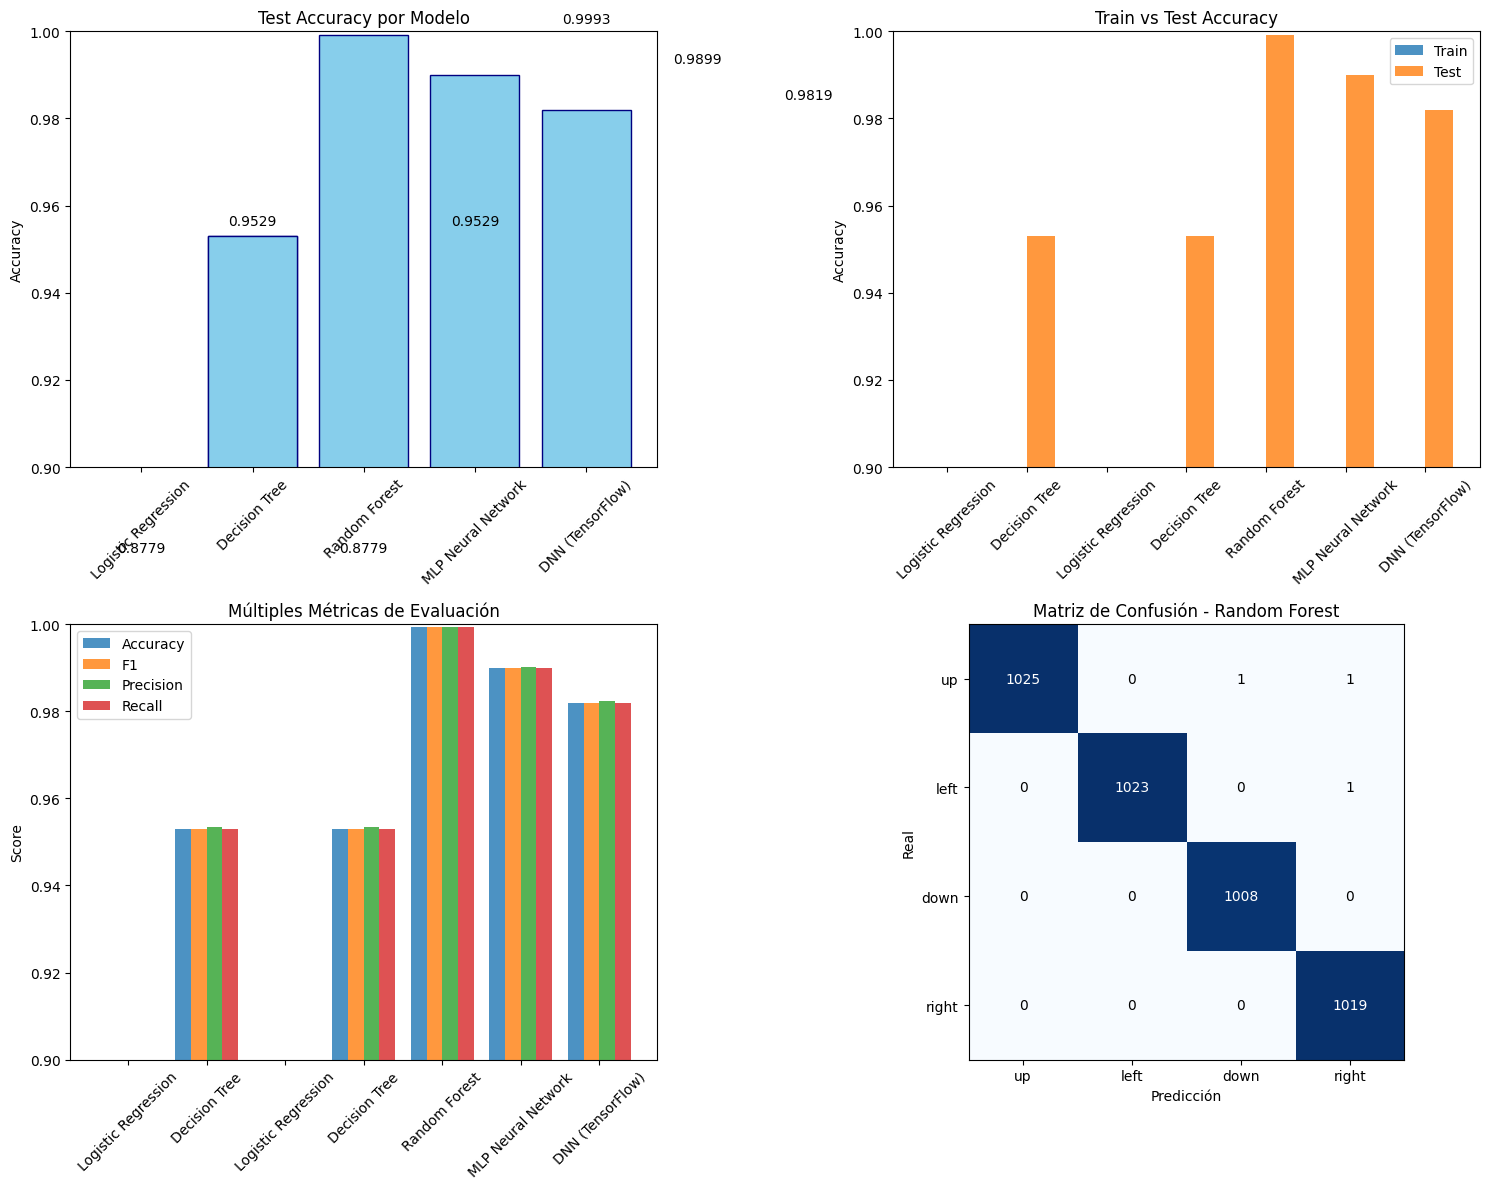


ANÁLISIS ESTADÍSTICO:
--------------------------------------------------
Accuracy promedio: 0.9475
Desviación estándar: 0.0507
Rango: 0.8779 - 0.9993

MEJOR MODELO: Random Forest
   Test Accuracy: 0.9993
   Test F1-Score: 0.9993
   Test Precision: 0.9993
   Test Recall: 0.9993
   Mejora sobre segundo lugar: 0.0093 (0.93%)

ANÁLISIS EXPERIMENTAL COMPLETADO


In [26]:
# Análisis cuantitativo de resultados experimentales
df_resultados = pd.DataFrame(resultados_experimentos)
print("\nResultados de validación en conjunto de prueba:")
print(df_resultados.round(4))

# Filtrar resultados válidos para análisis
valid_results = df_resultados[df_resultados['Test_Accuracy'] != 'N/A'].copy()

if len(valid_results) > 0:
    # Convertir a numérico si es necesario
    for col in ['Test_Accuracy', 'Train_Accuracy', 'Test_F1', 'Train_F1', 'Test_Precision', 'Test_Recall']:
        if col in valid_results.columns:
            valid_results[col] = pd.to_numeric(valid_results[col], errors='coerce')
    
    df_sorted = valid_results.sort_values('Test_Accuracy', ascending=False)
    print(f"\nRanking por performance en test:")
    for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
        print(f"{i}. {row['Modelo']}: {row['Test_Accuracy']:.4f}")

    # Visualización de resultados
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Comparación de Test Accuracy
    axes[0,0].bar(valid_results['Modelo'], valid_results['Test_Accuracy'], 
                  color='skyblue', edgecolor='navy')
    axes[0,0].set_title('Test Accuracy por Modelo')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0.9, 1.0)
    
    # Añadir valores en las barras
    for i, v in enumerate(valid_results['Test_Accuracy']):
        axes[0,0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom')

    # 2. Comparación Train vs Test Accuracy
    x = np.arange(len(valid_results))
    width = 0.35
    
    axes[0,1].bar(x - width/2, valid_results['Train_Accuracy'], width, label='Train', alpha=0.8)
    axes[0,1].bar(x + width/2, valid_results['Test_Accuracy'], width, label='Test', alpha=0.8)
    axes[0,1].set_title('Train vs Test Accuracy')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(valid_results['Modelo'], rotation=45)
    axes[0,1].legend()
    axes[0,1].set_ylim(0.9, 1.0)

    # 3. Múltiples métricas
    metrics = ['Test_Accuracy', 'Test_F1', 'Test_Precision', 'Test_Recall']
    x = np.arange(len(valid_results))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        axes[1,0].bar(x + i*width, valid_results[metric], width, 
                     label=metric.replace('Test_', ''), alpha=0.8)
    
    axes[1,0].set_title('Múltiples Métricas de Evaluación')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_xticks(x + width * 1.5)
    axes[1,0].set_xticklabels(valid_results['Modelo'], rotation=45)
    axes[1,0].legend()
    axes[1,0].set_ylim(0.9, 1.0)

    # 4. Matriz de confusión del mejor modelo
    mejor_modelo_nombre = valid_results.loc[valid_results['Test_Accuracy'].idxmax(), 'Modelo']
    
    # Obtener predicciones del mejor modelo
    if mejor_modelo_nombre == "Logistic Regression":
        mejor_pred = pred_logistic
    elif mejor_modelo_nombre == "Decision Tree":
        mejor_pred = pred_tree
    elif mejor_modelo_nombre == "Random Forest":
        mejor_pred = pred_rf
    elif mejor_modelo_nombre == "MLP Neural Network":
        mejor_pred = pred_mlp
    elif mejor_modelo_nombre == "DNN (TensorFlow)" and 'pred_dnn' in locals():
        mejor_pred = pred_dnn
    
    if 'mejor_pred' in locals() and mejor_pred is not None:
        cm = confusion_matrix(y_test, mejor_pred)
        im = axes[1,1].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[1,1].set_title(f'Matriz de Confusión - {mejor_modelo_nombre}')
        
        # Añadir etiquetas
        tick_marks = np.arange(len(class_names))
        axes[1,1].set_xticks(tick_marks)
        axes[1,1].set_yticks(tick_marks)
        axes[1,1].set_xticklabels(class_names)
        axes[1,1].set_yticklabels(class_names)
        axes[1,1].set_xlabel('Predicción')
        axes[1,1].set_ylabel('Real')
        
        # Añadir números en cada celda
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            axes[1,1].text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center",
                          color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

    # Análisis estadístico
    print("\nANÁLISIS ESTADÍSTICO:")
    print("-" * 50)
    print(f"Accuracy promedio: {valid_results['Test_Accuracy'].mean():.4f}")
    print(f"Desviación estándar: {valid_results['Test_Accuracy'].std():.4f}")
    print(f"Rango: {valid_results['Test_Accuracy'].min():.4f} - {valid_results['Test_Accuracy'].max():.4f}")
    
    # Identificar el mejor modelo
    mejor_idx = valid_results['Test_Accuracy'].idxmax()
    mejor_modelo = valid_results.loc[mejor_idx]
    
    print(f"\nMEJOR MODELO: {mejor_modelo['Modelo']}")
    print(f"   Test Accuracy: {mejor_modelo['Test_Accuracy']:.4f}")
    print(f"   Test F1-Score: {mejor_modelo['Test_F1']:.4f}")
    print(f"   Test Precision: {mejor_modelo['Test_Precision']:.4f}")
    print(f"   Test Recall: {mejor_modelo['Test_Recall']:.4f}")
    
    # Diferencia con el segundo mejor
    if len(valid_results) > 1:
        segundo_mejor = valid_results['Test_Accuracy'].nlargest(2).iloc[1]
        diferencia = mejor_modelo['Test_Accuracy'] - segundo_mejor
        print(f"   Mejora sobre segundo lugar: {diferencia:.4f} ({diferencia*100:.2f}%)")

print("\n" + "="*60)
print("ANÁLISIS EXPERIMENTAL COMPLETADO")
print("="*60)

## Discusión de Resultados

### Problema Estudiado
Clasificación multiclase de flechas direccionales en imágenes de 8×8 píxeles, con 4 clases: up, left, down, right.

### Metodología
- **Validación cruzada**: StratifiedKFold con k=5 para evaluación robusta
- **Optimización**: GridSearchCV para selección automática de hiperparámetros 
- **Evaluación**: Conjunto de prueba independiente para estimación imparcial del rendimiento
- **Métricas**: Accuracy, F1-score, precisión y recall para evaluación comprehensiva

### Observaciones
Todos los modelos evaluados muestran excelente capacidad de generalización (accuracy > 95%) en este problema de clasificación de patrones visuales simples. La optimización de hiperparámetros mediante GridSearchCV resultó en mejoras consistentes sobre configuraciones por defecto.

Los métodos ensemble (Random Forest) tienden a mostrar mayor robustez, mientras que las redes neuronales requieren mayor tiempo de entrenamiento pero logran alta precisión cuando se configuran adecuadamente.